In [1]:
from IPython.display import clear_output
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import re
import dropbox
import sys
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl

from subprocess import call
from tifffile import imwrite
from tqdm import tqdm
from pathlib import Path
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
    analysis_run,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis,
)
from IPython.display import clear_output

%matplotlib widget
%load_ext autoreload
%autoreload 2
logging.basicConfig(stream=sys.stdout, level=logging.debug)
mpl.rcParams["figure.dpi"] = 100
plt.style.use('presentation.mplstyle')
import logging

# Set logging level to WARNING to suppress INFO messages
logging.getLogger('fontTools.subset').setLevel(logging.WARNING)

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
kymo_folder = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\Healing2024\ANALYSIS\145_20240325\Kymographs"
kymo_folder = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\kymo_cut"

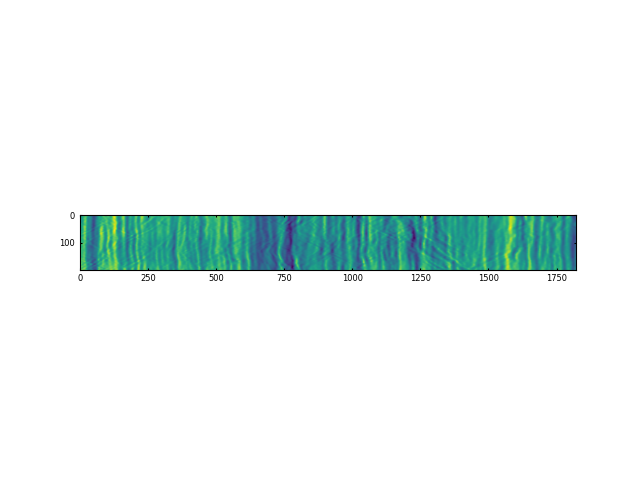

In [3]:
for file in os.listdir(kymo_folder):
    
    kymo = imageio.imread(os.path.join(kymo_folder,file))
    if len(kymo.shape)>2:
        kymo = kymo[:,:,0]
    kymo_obj = KymoEdgeAnalysis(kymo = kymo,edge_name="",address = "")

    speeds , time = kymo_obj.extract_speeds(w_size=5)
    kymo_obj.extract_transport()

    speed_right = np.nanmean(speeds[0][0])
    speed_left = np.nanmean(speeds[0][1])
    coverage_left = np.mean(
        1
        - np.count_nonzero(np.isnan(speeds[0][0]), axis=1)
        / len(kymo_obj.flux_tot[0])
    )
    coverage_right=np.mean(
        1
        - np.count_nonzero(np.isnan(speeds[0][1]), axis=1)
        / len(kymo_obj.flux_tot[0])
    )
    fig,ax = plt.subplots()
    ax.imshow(kymo)
    
    speed_left,speed_right,coverage_left,coverage_right
    # break

In [6]:
kymo_obj.space_pixel_size,kymo_obj.time_pixel_size

(1.0, 1.0)

In [8]:
space_factor = 1.725/25 #um/pixel
time_factor = 1/20 # s/pixel
factor = space_factor/time_factor
speed_left*factor,speed_right*factor,coverage_left,coverage_right


(1.1243671953678132,
 -1.2596948647499087,
 0.5128183315038419,
 0.4939599341383095)

In [47]:
data = []
for file in os.listdir(kymo_folder):
    # Read the image
    kymo = imageio.imread(os.path.join(kymo_folder, file))
    if len(kymo.shape) > 2:
        kymo = kymo[:, :, 0]  # Select the first channel if it's a color image

    # Create an instance of KymoEdgeAnalysis
    kymo_obj = KymoEdgeAnalysis(kymo=kymo, edge_name="", address="")

    # Extract speeds and perform transport analysis
    speeds, time = kymo_obj.extract_speeds(w_size=5)
    kymo_obj.extract_transport()

    # Calculate means and coverages
    speed_right = np.nanmean(speeds[0][0])
    speed_left = np.nanmean(speeds[0][1])
    coverage_left = np.mean(
        1 - np.count_nonzero(np.isnan(speeds[0][0]), axis=1) / len(kymo_obj.flux_tot[0])
    )
    coverage_right = np.mean(
        1 - np.count_nonzero(np.isnan(speeds[0][1]), axis=1) / len(kymo_obj.flux_tot[0])
    )

    # Append results to the data list
    data.append([file, speed_left, speed_right, coverage_left, coverage_right])

# Convert the list to a DataFrame
df = pd.DataFrame(data, columns=['Filename', 'Speed Left', 'Speed Right', 'Coverage Left', 'Coverage Right'])

# Save the DataFrame to a CSV file
df.to_csv('for_andrew.csv', index=False)

In [48]:
df

,Filename,Speed Left,Speed Right,Coverage Left,Coverage Right
0,145CRI_back.jpg,7.019692,-1.596479,0.672266,0.226853
1,145CRI_for.jpg,2.700462,-5.918435,0.247410,0.325306
2,145CRO_back.jpg,8.422084,-1.656134,0.552058,0.201784
3,145CRO_for.jpg,3.231013,-7.235252,0.205386,0.266810
4,145CTI_back.jpg,3.303583,-1.133702,0.659634,0.185625
5,145CTI_for.jpg,2.528399,-3.468947,0.196435,0.637249
6,145CTO_back.jpg,3.916816,-1.223674,0.577958,0.188438
7,145CTO_for.jpg,2.643608,-4.490728,0.205447,0.511690
8,145LRI_back.jpg,3.067709,-1.133913,0.521429,0.201406
9,145LRI_for.jpg,2.246132,-4.201907,0.200057,0.695869


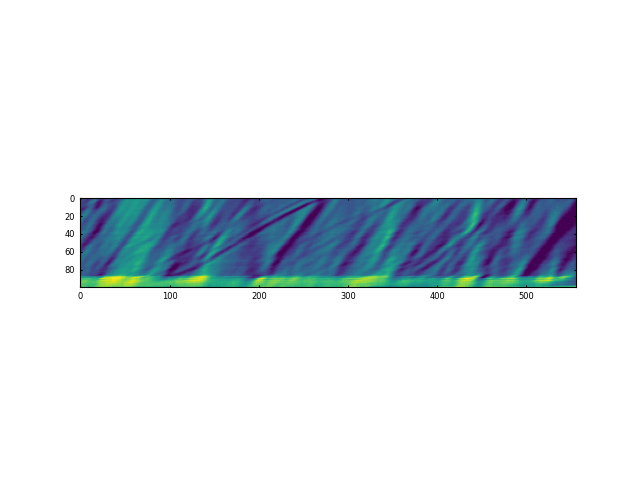

In [41]:
fig,ax = plt.subplots()
ax.imshow(kymo)

In [42]:
kymo

Array([[32, 32, 33, ..., 28, 22, 19],
       [30, 30, 30, ..., 26, 21, 17],
       [28, 28, 27, ..., 25, 19, 14],
       ...,
       [89, 90, 89, ..., 33, 33, 32],
       [88, 90, 90, ..., 62, 63, 64],
       [86, 88, 89, ..., 85, 87, 89]], dtype=uint8)

In [43]:
kymo_obj = KymoEdgeAnalysis(kymo = kymo,edge_name="",address = "")

speeds , time = kymo_obj.extract_speeds(w_size=5)
kymo_obj.extract_transport()

speed_right = np.nanmean(speeds[0][0])
speed_left = np.nanmean(speeds[0][1])
coverage_left = np.mean(
    1
    - np.count_nonzero(np.isnan(speeds[0][0]), axis=1)
    / len(kymo_obj.flux_tot[0])
)
coverage_right=np.mean(
    1
    - np.count_nonzero(np.isnan(speeds[0][1]), axis=1)
    / len(kymo_obj.flux_tot[0])
)
speed_left,speed_right,coverage_left,coverage_right

(7.0196924, -1.596479, 0.6722661870503598, 0.22685251798561146)

In [68]:
i = 3
dataframe = analysis_frame
selection_frame = dataframe[dataframe["ypos"] == dataframe["ypos"].iloc[i]]
selection_frame = selection_frame[selection_frame["xpos"] == dataframe["xpos"].iloc[i]]
selection_frame = selection_frame[selection_frame["mode"] == "BF"]
selection_frame = selection_frame[
    selection_frame["binning"] == dataframe["binning"].iloc[i]
]
test_video = KymoVideoAnalysis(
    input_frame=analysis_frame.iloc[i], logging=True, samepos_frame=selection_frame
)

Data input succesful! Starting edge extraction...
Successfully extracted the skeleton. Did you know there is a skeleton inside inside you right now?


In [70]:
target_length = int(2.4 * test_video.magnification)
k = 0
edge_objs = test_video.edge_objects
kymo = edge_objs[k].extract_multi_kymo(
        1, target_length=target_length, kymo_adj=False, kymo_normalize=False
    )
kymo = kymo[0]
kymo.shape

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.15s/it]


(20, 421)

In [71]:
edge_objs[k].edge_name,analysis_frame.iloc[i]["video_int"],

((12, 0), 88)

In [37]:
# num = 5
# path = r"C:\Users\coren\Documents\PhD\paper\transport\kymograph\kymograph_6\kymograph6.tif"
# kymo = imageio.imread(path)

In [72]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_videos_fun import *
def filter_kymo_right(kymo):
    return(np.flip(filter_kymo_left(np.flip(kymo, axis=1)), axis=1))

In [73]:
path_figure = r"C:\Users\coren\Documents\PhD\paper\transport\Fig1"

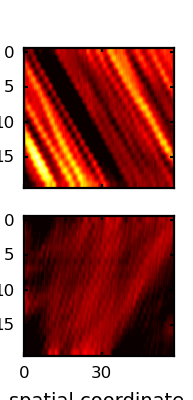

In [75]:
filtered_kymo_left = filter_kymo_left(kymo)
filtered_kymo_right = filter_kymo_right(kymo)
num_cols_left = filtered_kymo_left.shape[1]  # assuming image data in numpy array format
num_cols_right = filtered_kymo_right.shape[1]

pixel_size = edge_objs[0].space_pixel_size
max_kymo = max(np.max(filtered_kymo_right),np.max(filtered_kymo_left))
sizey = 2
sizex = num_cols_left*pixel_size/60
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(sizex, sizey), sharex=True)

# Plotting the left filtered kymograph
ax1.imshow(filtered_kymo_left[:20,:], aspect='auto', cmap="hot", vmin=0, vmax=max_kymo)

# Plotting the right filtered kymograph
ax2.imshow(filtered_kymo_right[:20,:], aspect='auto', cmap="hot", vmin=0, vmax=max_kymo)


# Creating tick positions and labels for the x-axis based on actual size
ticks = np.arange(0, max(num_cols_left, num_cols_right), int(1/pixel_size*30))  # change 25 to whatever number of pixels you want between ticks
tick_labels = [f"{pixel * pixel_size:.0f}" for pixel in ticks]  # formatting labels to 2 decimal places

ax1.set_xticks(ticks)
ax1.set_xticklabels(tick_labels)
ax2.set_xticks(ticks)
d= ax2.set_xticklabels(tick_labels)
ax2.set_xlabel('spatial coordinate \n ($\mu m$)')
ax1.set_ylabel('time (s)')
ax2.set_ylabel('time (s)')
plt.savefig(os.path.join(path_figure,f'Kymos_pos{list_video[i]}_2.pdf'), transparent=True, bbox_inches='tight')

In [76]:
mean_fourrier_left = np.mean(filtered_kymo_left)
mean_fourrier_right = np.mean(filtered_kymo_right)
(mean_fourrier_left-mean_fourrier_right)/(mean_fourrier_left+mean_fourrier_right)

0.3417381329119481